#ML4Net - Lab 2

## Team members

Alba Yerga (252197) | Marc Sirvent (240198)

## Description

In this lab, you will implement an ML model that detects congestion in Wi-Fi networks. In particular, you will desing and implement a supervised learning model (e.g., linear regression, multi-layer perceptron, neural network), which you will train using a dataset that was generated using the ns-3 simulator.

Each row in the dataset is organized as (x1, x2, ..., x26, y1, y2, ..., y26, s, r, l), where:

* `x1, x2..., x26, y1, y2, ..., y26` represent the histogram of the Inter-Frame Space (IFS) values for M frames that accessed the medium in a 60 seconds observation sample.
  * `x26` represents the maximum IFS duration (in ms) in the considered M frames whereas `x1` is `x26`/26
  * The remaining `xi` values are buckets at uniform spacing between `x1` and `x26`.
  * For i>1, the values of `yi` represent the IFS histogram count (in percentage) for a corresponding bucket interval between `xi`-1 and `xi`.
  * In the case of `y1`, the bucket interval is between 0 and `x1`
* `s` is the average IFS duration (in ms)
* `r` is the percentage of frame collisions
* `l` is the label, where 1 indicates that the network is saturated, and 0, that it is not

Original dataset: https://ieee-dataport.org/documents/dataset-identification-saturated-and-unsaturated-wi-fi-networks

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   Submission deadline: 1 June 2025 (EoB).

# Necessary imports

In [148]:
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

## Setting up the environment

1. Connect your Google Drive

In [149]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Download the dataset

In [150]:
!wget https://github.com/fwilhelmi/fwilhelmi.github.io/raw/refs/heads/master/files/dataset_Lab2.zip

--2025-05-28 17:53:21--  https://github.com/fwilhelmi/fwilhelmi.github.io/raw/refs/heads/master/files/dataset_Lab2.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fwilhelmi/fwilhelmi.github.io/refs/heads/master/files/dataset_Lab2.zip [following]
--2025-05-28 17:53:21--  https://raw.githubusercontent.com/fwilhelmi/fwilhelmi.github.io/refs/heads/master/files/dataset_Lab2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1803279 (1.7M) [application/zip]
Saving to: ‘dataset_Lab2.zip.1’

dataset_Lab2.zip.1  100%[===================>]   1.72M  --.-KB/s    in 0.06s   

2025-05-28 17:53:21 (29.0 M

3. Define the main path of the code

In [151]:
mypath="/content/drive/Shareddrives/LAB2-ML"
%cd "/content/drive/Shareddrives/LAB2-ML"
!ls

/content/drive/Shareddrives/LAB2-ML
AAX_Lab2_252197_240198.ipynb  dataset_Lab2.zip.1  test_data.csv
dataset_Lab2.zip	      __MACOSX		  train_data.csv


4. Extract the source code to the destination folder

In [152]:
mkdir $mypath; cp dataset_Lab2.zip $mypath; cd $mypath; unzip dataset_Lab2.zip

mkdir: cannot create directory ‘/content/drive/Shareddrives/LAB2-ML’: File exists
cp: 'dataset_Lab2.zip' and '/content/drive/Shareddrives/LAB2-ML/dataset_Lab2.zip' are the same file
Archive:  dataset_Lab2.zip
replace test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._train_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Visualizing the data




       0       1       2       3       4       5       6       7       8   \
0  0.0065  0.0130  0.0195  0.0260  0.0325  0.0390  0.0455  0.0520  0.0585   
1  0.0263  0.0526  0.0789  0.1052  0.1316  0.1579  0.1842  0.2105  0.2368   
2  0.0176  0.0352  0.0528  0.0704  0.0881  0.1057  0.1233  0.1409  0.1585   
3  0.0222  0.0444  0.0666  0.0888  0.1110  0.1332  0.1554  0.1776  0.1998   
4  0.0189  0.0379  0.0568  0.0758  0.0947  0.1137  0.1326  0.1516  0.1705   

       9   ...      45      46      47      48      49      50      51  \
0  0.0650  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   
1  0.2631  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   
2  0.1761  ...  0.0316  0.0368  0.0312  0.0312  0.0316  0.0299  0.0304   
3  0.2220  ...  0.0316  0.0307  0.0312  0.0000  0.0360  0.0364  0.0304   
4  0.1895  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   

       52      53  54  
0  0.0604  0.9960   1  
1  0.0604  0.9960   1  
2  0.0604  0.9957   

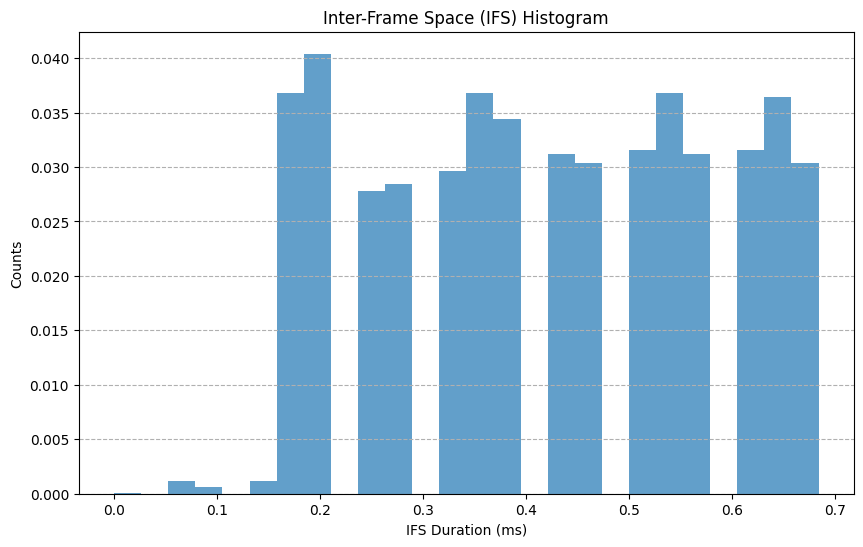

In [153]:
def plot_ifs_histogram(data_row):
    """
    Plots the Inter-Frame Space (IFS) histogram from a single row of the dataset.

    Args:
        data_row (list or numpy.ndarray): A list or array representing a single row
                                          in the format (x1, ..., x26, y1, ..., y26, s, r, l).
    """

    # Get IFS values and the corresponding counts
    x_values = np.array(data_row[:26])
    y_counts = np.array(data_row[26:52])

    # Calculate the bin edges based on x_values
    bin_edges = [0] + list(x_values)

    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], y_counts, width=np.diff(bin_edges)[0], align='edge', alpha=0.7)

    # Add labels and title
    plt.xlabel("IFS Duration (ms)")
    plt.ylabel("Counts")
    plt.title("Inter-Frame Space (IFS) Histogram")
    plt.grid(axis='y', linestyle='--')

    # Show the plot
    plt.show()

# Example usage

# -> Read the data file
file_name = mypath + '/train_data.csv'
train_data_df = pd.read_csv(file_name, header=None)
print(train_data_df.head())

# -> Get a sample from the dataset and plot it
row_index = 1
sample_data = train_data_df.iloc[row_index].values
plot_ifs_histogram(sample_data)

## EXERCISES

### Exercise 1:
Define an approach for training and validating the model you are going to train with the proposed data. Then, perform the split accordingly.

In [154]:
# (response to exercise 1)
"""
  For the split we will use a classic 90% train and 10% val for it we will use the already implemented train_test_split from sklearn

  We only use the last 2 columns 's' and 'r' as meaningful features as they are quite predictive of the network saturation
  Also the other columns x1...x26 and y1...y26 could add some noise or redundant information to the model.
  We tested with the 'r' and 's' columns which gave us better results than with the other.

"""

train_df, val_df = train_test_split(train_data_df, test_size=0.1, random_state=42)

# Create the full list of column names
x_cols = [f'x{i}' for i in range(1, 27)]
y_cols = [f'y{i}' for i in range(1, 27)]
other_cols = ['s', 'r', 'l']
column_names = x_cols + y_cols + other_cols

train_df.columns = column_names
val_df.columns = column_names

X_train = train_df[['s', 'r']]
y_train = train_df['l']

X_val = val_df[['s', 'r']]
y_val = val_df['l']

### Exercise 2:

Define your ML model, so that it can be called for training and test. Examples of approaches that you could use (but not limited to):

*   Logistic Regression
*   K-Nearest Neighbors (KNN)
*   Decision Trees or Random Forests
*   Convolutional Neural Network (CNN)

In [155]:
# (response to exercise 2)

# We have choosen to use a LogisticRegression with gradient descent as it works well for binary classification.

class LogisticRegressionGD:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
        self.theta = None
        self.cost_history = []

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __add_intercept(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]

    def __compute_cost(self, h, y):
        m = len(y)
        return - (1/m) * np.sum(y*np.log(h) + (1 - y)*np.log(1 - h))

    def fit(self, X, y):
        X = self.__add_intercept(X)
        self.theta = np.zeros(X.shape[1])

        for _ in range(self.n_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            self.cost_history.append(self.__compute_cost(h, y))

        return self

    def predict_proba(self, X):
        X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X):
        return self.predict_proba(X) >= 0.5

    def plot_training_loss(self, interval=100):
        iterations = np.arange(len(self.cost_history))
        sampled_iters = iterations[::interval]
        sampled_costs = self.cost_history[::interval]

        plt.figure(figsize=(8, 5))
        plt.plot(sampled_iters, sampled_costs, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Log Loss')
        plt.title(f'Training Loss every {interval} iterations')
        plt.grid(True)
        plt.show()

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print("Evaluation on Test Set:")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1 Score : {f1:.4f}")
        print("Confusion Matrix:")
        cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0 (not saturated)', 'Actual 1(saturated)'])
        print(cm)

        return self

### Exercise 3:

Define the hyperparameters that you will use to train the model.

In [156]:
# (response to exercise 3)
# Hyperparameters
iterations = 20000
learning_rate = 0.05 # We tested with different learning rates and this gave us better results than lower lr's

# Initialize the model
model = LogisticRegressionGD(n_iter= iterations, lr= learning_rate)

### Exercise 4:
Train the model and show the procedure (e.g., evolution of the training/validation loss).

In [157]:
# (response to exercise 4)

# Model fit
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

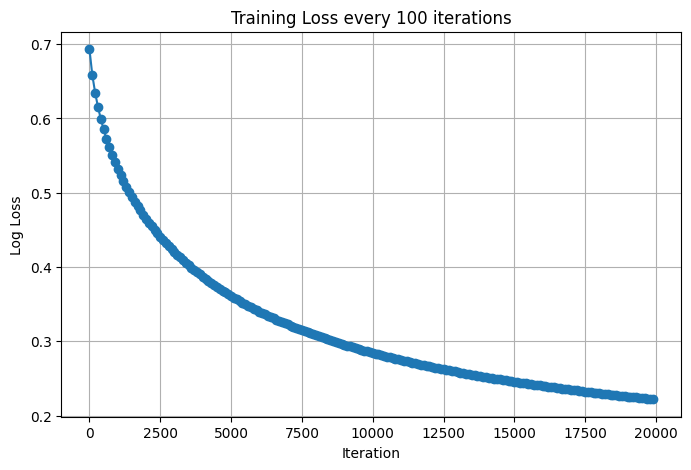

In [158]:
model.plot_training_loss()

### Exercise 5:

Select and define the most appropriate evaluation metric(s). Discuss the appropriateness of your evaluation metrics for the binary classification problem we are considering.

In [159]:
# (response to exercise 5)
"""
  For the evaluation of the model we use the primary metrics of Accuracy, Precision, Recall and F1 Score.
  We aim to maximize the Recall for the use case, as we want to catch all the actual congested networks
  All this methods are implemented inside the model definition.
"""
model.evaluate(X_val, y_val)

Evaluation on Test Set:
Accuracy : 0.9730
Precision: 0.9949
Recall   : 0.9521
F1 Score : 0.9730
Confusion Matrix:
                          Predicted 0  Predicted 1
Actual 0 (not saturated)          972            5
Actual 1(saturated)                49          974


### Exercise 6:

Evaluate your trained model on the test set, using the evaluation metrics that you have proposed. Remember that the test data should have not been seen by the model, so that we can properly estimate of its generalization capabilities.

In [160]:
# (response to exercise 6)
# We get the test dataset (unseen from the model) and test it with our previously mentioned evaluation metrics.
test_dataset = pd.read_csv(mypath + '/test_data.csv', header=None)
test_dataset.columns = column_names
X_test = test_dataset[['s', 'r']]
y_test = test_dataset['l']

model.evaluate(X_test, y_test)

Evaluation on Test Set:
Accuracy : 0.9400
Precision: 0.8966
Recall   : 1.0000
F1 Score : 0.9455
Confusion Matrix:
                          Predicted 0  Predicted 1
Actual 0 (not saturated)          210           30
Actual 1(saturated)                 0          260


### Evaluation commentary:

As we observed the Recall is 1, that means that we caught all the actual congested networks which was our objective, we also have 30 False Positives but we are not so concerned about our model getting a low percentage of false positives because its better to say that the network is saturated and its not than the inverse. Still its not perfect but our model is well balanced and generalizes good with completely unseen data as its the case with the test dataset.